# 6. Decision Trees and Ensemble Learning

In [61]:
import pandas as pd
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt

# 6.2 Data cleaning and preparation

In [2]:
# !wget 'https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv'

In [3]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [4]:
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Decode categorical variables back to strings
To learn how the data was pre-processed. Look at this [R file](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R)

In [5]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [7]:
status_values = {1: 'ok', 2: 'default', 0: 'unk'}
df.status = df.status.map(status_values)

In [8]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [9]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


## Handle missing values

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [11]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [13]:
df = df[df.status != 'unk'].reset_index(drop=True)
df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,default,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4450,ok,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4451,default,0,owner,24,37,married,no,partime,60,90.0,3500.0,0.0,500,963
4452,ok,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


## Train validation split

In [14]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [15]:
y_train = (df_train.status == 'default').astype(int)
y_val = (df_val.status == 'default').astype(int)
y_test = (df_test.status == 'default').astype(int)

In [16]:
del df_train['status']
del df_val['status']
del df_test['status']

In [17]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


# 6.3 Decision trees

## Simple decision tree

In [18]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [19]:
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [20]:
assess_risk(xi)

'ok'

## Sklearn decision tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [22]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]])

In [23]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
val_dicts = df_val.fillna(0).to_dict('records')
X_val = dv.transform(val_dicts)

y_pred = dt.predict_proba(X_val)[:, 1]

In [26]:
roc_auc_score(y_val, y_pred)

np.float64(0.6437419776706789)

- Model is overfitting, roc auc score is 1 for training dataset and 0.65 for validation dataset
- Memorizing dataset and struggling to understand unseen data. This is because the model is too complex
- Overfitted because the tree is too deep, unrestricted depth

In [27]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

np.float64(1.0)

## Hyperparameter tuning

- Modify max_depth to improve model performance
- Model performs better when depth is restricted
- Decision tree with depth = 1 is called a **decision stump**

In [28]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

np.float64(0.7761016984958594)

In [29]:
X_val = dv.transform(val_dicts)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7389079944782155)

In [30]:
# visualize tree rules
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



# 6.4 Decision tree learning algorithm
## Terminilogy

1. Condition node
1. Decision node / leaf node
1. Split
1. Misclassification rate / impurity: fractions of error after prediction. Used to evaluate quality of split
1. Weighted average
1. Stopping criteria: stop when:
    - Group already pure
    - Tree reaches depth limit
    - Minimum group size: stop when group in split is too small

## Decision tree learning algorithm
- Find the best split for each node
- Stop if max depth is reached
- If left is sufficiently large and not pure -> repeat for left
- If right is sufficiently large and not pure -> repeat for right

[Sklearn decision tree](https://scikit-learn.org/1.5/modules/tree.html)

In [31]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [32]:
df_example.sort_values('assets') # to determine best split

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [33]:
from IPython.display import display


Best split is 3000 with impurity of 10%

In [34]:
# list of potential thresholds
Ts = [0, 2000, 3000, 4000, 5000, 8000]

for T in Ts:
    print(f"Threshold: {T}")
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))

    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()



Threshold: 0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

Threshold: 2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

Threshold: 3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

Threshold: 4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

Threshold: 5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

Threshold: 8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [35]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [36]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


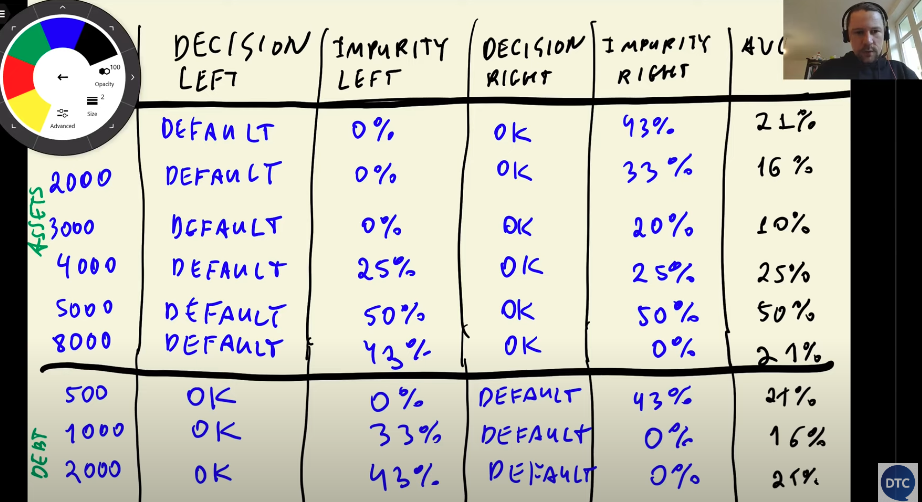

- Best split is asset=3000 with impurity of 10% and debt=1000 with impurity of 16%

In [37]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [38]:

for feature, Ts in thresholds.items():
    print('#####################')
    print(f"Feature = {feature}")
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
Feature = assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
Feature = debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


# 6.5 Decision trees parameter tuning

In [39]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"AUC for depth {d}: {auc:.3f}")

# 4 and 5 are good max depths

AUC for depth 1: 0.606
AUC for depth 2: 0.669
AUC for depth 3: 0.739
AUC for depth 4: 0.761
AUC for depth 5: 0.767
AUC for depth 6: 0.758
AUC for depth 10: 0.694
AUC for depth 15: 0.654
AUC for depth 20: 0.665
AUC for depth None: 0.649


In [40]:
scores = []

for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        print(f"AUC for depth {d} and leaf size {s}: {auc:.3f}")

        scores.append((d, s, auc))

AUC for depth 4 and leaf size 1: 0.761
AUC for depth 4 and leaf size 5: 0.761
AUC for depth 4 and leaf size 10: 0.761
AUC for depth 4 and leaf size 15: 0.764
AUC for depth 4 and leaf size 20: 0.761
AUC for depth 4 and leaf size 500: 0.680
AUC for depth 4 and leaf size 100: 0.756
AUC for depth 4 and leaf size 200: 0.747
AUC for depth 5 and leaf size 1: 0.767
AUC for depth 5 and leaf size 5: 0.768
AUC for depth 5 and leaf size 10: 0.762
AUC for depth 5 and leaf size 15: 0.773
AUC for depth 5 and leaf size 20: 0.774
AUC for depth 5 and leaf size 500: 0.680
AUC for depth 5 and leaf size 100: 0.763
AUC for depth 5 and leaf size 200: 0.759
AUC for depth 6 and leaf size 1: 0.761
AUC for depth 6 and leaf size 5: 0.762
AUC for depth 6 and leaf size 10: 0.778
AUC for depth 6 and leaf size 15: 0.785
AUC for depth 6 and leaf size 20: 0.773
AUC for depth 6 and leaf size 500: 0.680
AUC for depth 6 and leaf size 100: 0.776
AUC for depth 6 and leaf size 200: 0.768
AUC for depth 7 and leaf size 1: 0.74

In [41]:
scores

[(4, 1, np.float64(0.7612827250490422)),
 (4, 5, np.float64(0.7612827250490422)),
 (4, 10, np.float64(0.7612827250490422)),
 (4, 15, np.float64(0.7637257513743916)),
 (4, 20, np.float64(0.760910367876777)),
 (4, 500, np.float64(0.679842459615897)),
 (4, 100, np.float64(0.7559365236976581)),
 (4, 200, np.float64(0.7472602988544719)),
 (5, 1, np.float64(0.7669377103969388)),
 (5, 5, np.float64(0.7677550797994721)),
 (5, 10, np.float64(0.7622756775084158)),
 (5, 15, np.float64(0.7727228693904241)),
 (5, 20, np.float64(0.7740276331403937)),
 (5, 500, np.float64(0.679842459615897)),
 (5, 100, np.float64(0.7633836671429609)),
 (5, 200, np.float64(0.7590728003681189)),
 (6, 1, np.float64(0.7607680850548546)),
 (6, 5, np.float64(0.7623301688019181)),
 (6, 10, np.float64(0.7782991450921508)),
 (6, 15, np.float64(0.7848562640769174)),
 (6, 20, np.float64(0.7733374100893656)),
 (6, 500, np.float64(0.679842459615897)),
 (6, 100, np.float64(0.7764343319367417)),
 (6, 200, np.float64(0.7682666924995

In [42]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='auc', ascending=False, inplace=True)
df_scores

,max_depth,min_samples_leaf,auc
35,10.0,15,0.789888
51,20.0,15,0.787127
43,15.0,15,0.786836
59,NaN,15,0.785453
19,6.0,15,0.784856
...,...,...,...
29,7.0,500,0.679842
37,10.0,500,0.679842
48,20.0,1,0.675444
40,15.0,1,0.666640


In [43]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values='auc').round(3)
df_scores_pivot

max_depth,NaN,4.0,5.0,6.0,7.0,10.0,15.0,20.0
min_samples_leaf,,,,,,,,
1,0.652,0.761,0.767,0.761,0.748,0.683,0.667,0.675
5,0.715,0.761,0.768,0.762,0.758,0.728,0.716,0.717
10,0.763,0.761,0.762,0.778,0.765,0.772,0.764,0.764
15,0.785,0.764,0.773,0.785,0.780,0.790,0.787,0.787
20,0.780,0.761,0.774,0.773,0.779,0.783,0.782,0.782
100,0.779,0.756,0.763,0.776,0.780,0.779,0.779,0.780
200,0.768,0.747,0.759,0.768,0.768,0.768,0.768,0.768
500,0.680,0.680,0.680,0.680,0.680,0.680,0.680,0.680


This way of selecting parameters could be sub-optimal, but it is a good way to start

<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

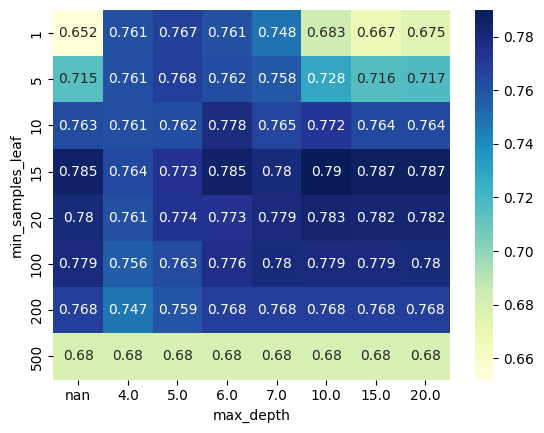

In [44]:
sns.heatmap(df_scores_pivot, annot=True, fmt="g", cmap="YlGnBu")

In [45]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7852498123077667)

# 6.6 Ensemble learning and random forest

- Random forest: Different decision trees trained on different features to make the final prediction. Each model gets a random subset of features
- The differnt decision trees can be looked at as a **board of experts** that can make a prediction

## Notes
**Ensemble learning** is a machine learning paradigm where multiple models, often referred to as 'weak learners', are strategically combined to solve a particular computational intelligence problem. This approach frequently yields superior predictive performance compared to using a single model.

**Random Forest** is an example of ensemble learning where each model is a decision tree and their predictions are aggregated to identify the most popular result. Random forest only selects a random subset of features from the original data to make predictions. The 'randomness' in Random Forest stems from two key aspects: 

- Each tree is potentially trained on a bootstrapped sample of the original data, introducing randomness at the row level.
- At each node during tree construction, only a random subset of features is considered for splitting. This feature randomness helps decorrelate the trees, preventing overfitting and promoting generalization to unseen data.

**Bootstrapping** is a resampling technique where numerous subsets
of the data are created by sampling the original data with replacement. This means that
some data points may appear multiple times in a single bootstrap sample, while others may
be excluded. In Random Forest, each decision tree is trained on a distinct bootstrap sample,
further contributing to the diversity and robustness of the ensemble.

**Parameter tuning** is crucial for optimizing the performance of a
Random Forest model.  Two critical parameters are `max_depth`, which controls the maximum
depth of each decision tree, and `n_estimators`, which determines the number of trees in
the forest. Increasing `max_depth` allows for more complex trees, potentially leading to
overfitting. Conversely, a larger `n_estimators` generally improves model accuracy but
increases computational cost.

In random forests, the decision trees are trained independently to each other.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# n_estimators -> number of decision trees
rf = RandomForestClassifier(n_estimators=10, random_state=1) # random_state is for reproducibility
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [56]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred) # result changes everytime you train it

np.float64(0.7744726453706618)

In [58]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1) # random_state is for reproducibility
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred) 
    scores.append((n, auc))

In [60]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


Text(0, 0.5, 'AUC')

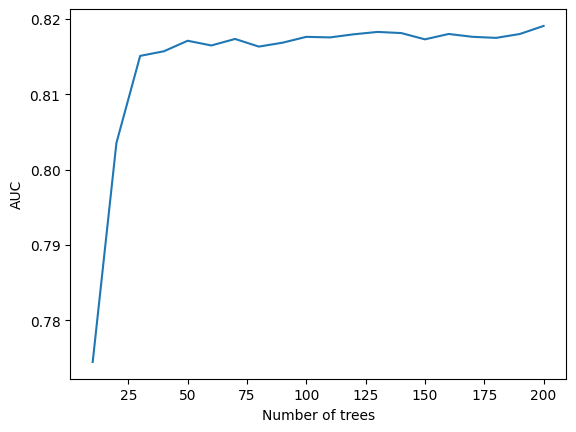

In [63]:
plt.plot(df_scores.n_estimators, df_scores.auc) # stagnates after 50 trees
plt.xlabel('Number of trees')
plt.ylabel('AUC')

## Parameter tuning
- Similar to tuning in decision trees
- Full list of parameters that can be tuned can be found in the [Scikit-learn documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### Max depth

In [64]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1) # random_state is for reproducibility
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred) 
        scores.append((n, d, auc))

In [66]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'auc'])
df_scores.head()

,n_estimators,max_depth,auc
0,10,5,0.787699
1,20,5,0.797731
2,30,5,0.800305
3,40,5,0.799708
4,50,5,0.799878


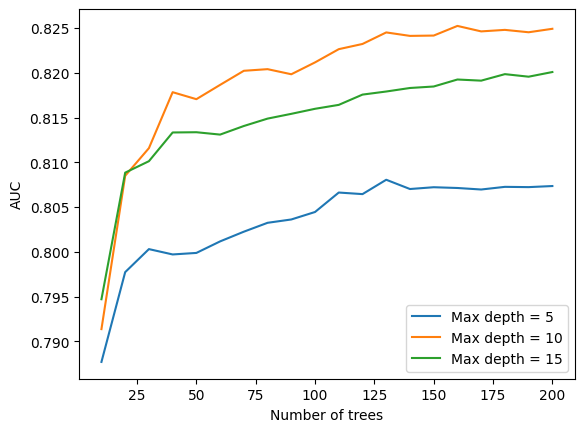

In [ ]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f'Max depth = {d}') # s10 is the best depth
    plt.xlabel('Number of trees')
    plt.ylabel('AUC')

plt.legend()

In [70]:
max_depth = 10

### Min samples leaf

In [83]:
scores = []
min_sample_leaves = [1, 3, 5, 10, 50]

for l in min_sample_leaves:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=l, random_state=1) # random_state is for reproducibility
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred) 
        scores.append((n, l, auc))

In [84]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'min_samples_leaf', 'auc'])
df_scores.head()

,n_estimators,min_samples_leaf,auc
0,10,1,0.791365
1,20,1,0.808496
2,30,1,0.811584
3,40,1,0.817839
4,50,1,0.817058


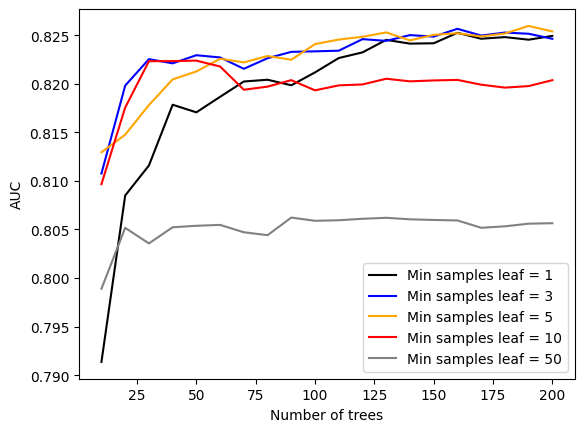

In [89]:
colors = ['black', 'blue', 'orange', 'red', 'grey']

for l, color in zip(min_sample_leaves, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == l]
    plt.plot(df_subset.n_estimators, df_subset.auc, color=color, label=f'Min samples leaf = {l}') # s10 is the best depth
    plt.xlabel('Number of trees')
    plt.ylabel('AUC')

plt.legend()

1, 3 and 5 has almost similar performance. Can go with 3, performance improved earlier than the rest
50 is the worst performer

In [90]:
min_samples_leaf = 3

In [91]:
rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1) # random_state is for reproducibility
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred) 
auc

np.float64(0.8246258264512848)

# 6.7 Gradient boosting and XGBoost
- XGBoost is prone to overfitting, so we need to be careful about number of rounds


## Gradient Boosting

Unlike Random Forest where each decision tree trains independently, in the Gradient Boosting Trees, the models are combined sequentially, where each model takes the prediction errors made by the previous model and then tries to improve the prediction. This process continues to `n` number of iterations, and in the end, all the predictions get combined to make the final prediction.

XGBoost is one of the libraries which implements the gradient boosting technique. To make use of the library, we need to install with `pip install xgboost`. To train and evaluate the model, we need to wrap our train and validation data into a special data structure from XGBoost which is called `DMatrix`. This data structure is optimized to train XGBoost models faster.

## XGBoost Training Parameters

[XGB Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)


*   `eta`: learning rate, which indicates how fast the model learns.
*   `max_depth`: to control the size of the trees.
*   `min_child_weight`: to control the minimum size of a child node.
*   `objective`: To specify which problem we are trying to solve, either regression, or classification (binary: `'binary:logistic'`, or other).
*   `nthread`: 8, used for parallelized training.
*   `seed`: 1, for reproducibility.
*   `verbosity`: 1 (`True`) to show warnings, if any, during model training.

## Classes, functions, and methods:

- `xgb.train()`: method to train xgboost model.
- `xgb_params`: key-value pairs of hyperparameters to train xgboost model.
- `watchlist`: list to store training and validation data to evaluate the performance of the model after each training iteration. The list takes tuple of train and validation set from DMatrix wrapper, for example, `watchlist = [(dtrain, 'train'), (dval, 'val')]`.
- `%%capture output`: IPython magic command which captures the standard output and standard error of a cell.

In [116]:
import xgboost as xgb

In [117]:
features = list(dv.get_feature_names_out())

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [122]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [123]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred) # really good performance

np.float64(0.8065256351262986)

## Monitor model during training

In [ ]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [133]:
s = output.stdout

In [134]:
print(s)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [169]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        num_iter, train_auc, val_auc = line.split('\t')

        it = int(num_iter.strip('[]'))
        train = float(train_auc.split(':')[1])
        val = float(val_auc.split(':')[1])

        results.append((it, train, val))

    columns = ['iteration', 'train_auc', 'val_auc']
    df = pd.DataFrame(results, columns=columns)

    return df

In [171]:
df_score = parse_xgb_output(output)
df_score.head()

,iteration,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729


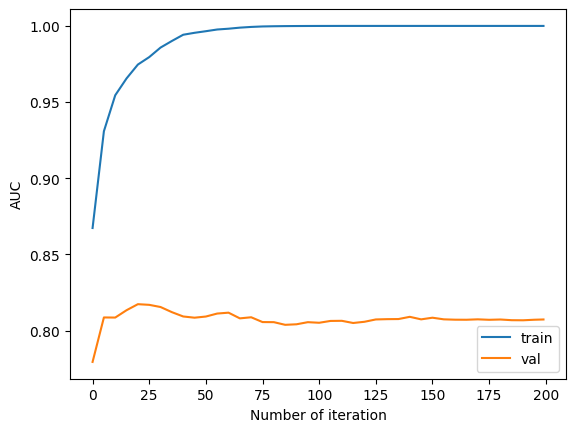

In [175]:
plt.plot(df_score.iteration, df_score.train_auc, label='train')
plt.plot(df_score.iteration, df_score.val_auc, label='val')

plt.xlabel('Number of iteration')
plt.ylabel('AUC')

plt.legend()

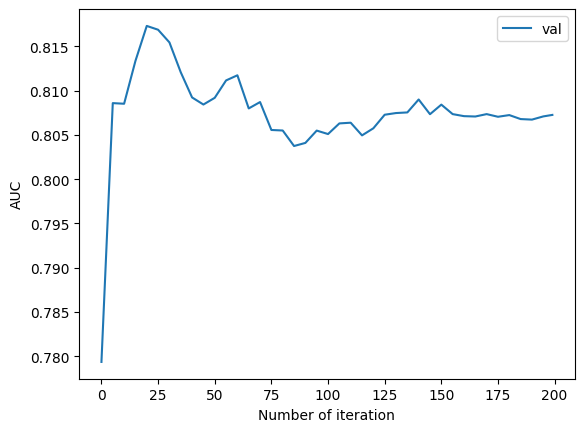

In [176]:
plt.plot(df_score.iteration, df_score.val_auc, label='val')

plt.xlabel('Number of iteration')
plt.ylabel('AUC')

plt.legend()

Starts overfitting at around iteration 75

# 6.8 XGBoost parameter tuning

## Notes

XGBoost has various tunable parameters but the three most important ones are:

- `eta` (default=0.3)
  - It is also called `learning_rate` and is used to prevent overfitting by regularizing the weights of new features in each boosting step. range: [0, 1]
- `max_depth` (default=6)
  - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. range: [0, inf]
- `min_child_weight` (default=1)
  - Minimum number of samples in leaf node. range: [0, inf]

For XGBoost models, there are other ways of finding the best parameters as well but the one we implement in the notebook follows the sequence of:

- First find the best value for `eta`
- Second, find the best value for `max_depth`
- Third, find the best value for `min_child_weight`

Other useful parameter are:

- `subsample` (default=1)
  - Subsample ratio of the training instances. Setting it to 0.5 means that model would randomly sample half of the training data prior to growing trees. range: (0, 1]
- `colsample_bytree` (default=1)
  - This is similar to random forest, where each tree is made with the subset of randomly choosen features.
- `lambda` (default=1)
  - Also called `reg_lambda`. L2 regularization term on weights. Increasing this value will make model more conservative.
- `alpha` (default=0)
  - Also called `reg_alpha`. L1 regularization term on weights. Increasing this value will make model more conservative.

## ETA
- Also called **learning rate** or size of the step
- Weight that a subsequent model has when correcting predictions from previous models. If eta is 1.0, corrects all prior predictions. If eta is 0.1, corrects only 10% of the previous predictions

In [198]:
scores = {}

eta_keys = [0.3, 1.0, 0.1, 0.05, 0.01]

In [210]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [211]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

scores.keys()

dict_keys(['eta=0.01', 'eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05'])

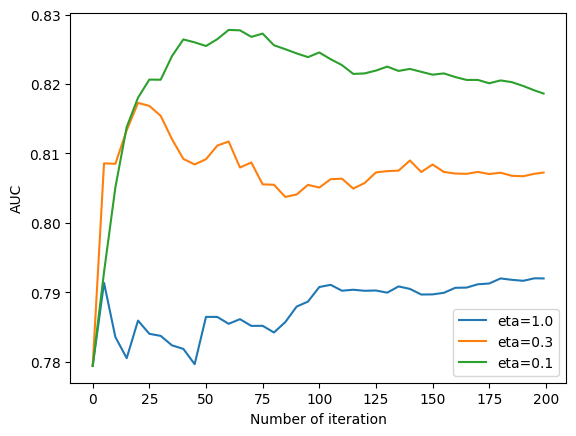

In [218]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']

# for key, df_score in scores.items():
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.iteration, df_score.val_auc, label=eta)

plt.xlabel('Number of iteration')
plt.ylabel('AUC')

plt.legend()

- 1.0 is the worst and 0.1 has the best AUC. Peaks at around 75 iteration then starts to degrade
- 0.1 starts slow but learns better
- 0.3 starts okay then overfits later on

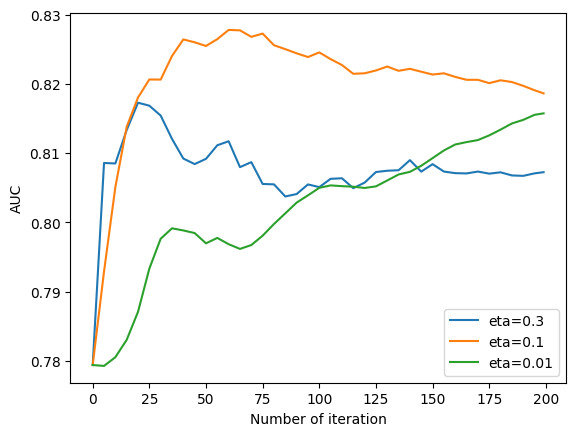

In [219]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']

# for key, df_score in scores.items():
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.iteration, df_score.val_auc, label=eta)

plt.xlabel('Number of iteration')
plt.ylabel('AUC')

plt.legend()

- 0.01 learsnn very slowly, we're not sure of when it will start to improve (number of iterations needed)
- 0.3 takes big steps in learning but starts to overfit faster
- 0.1 still the best

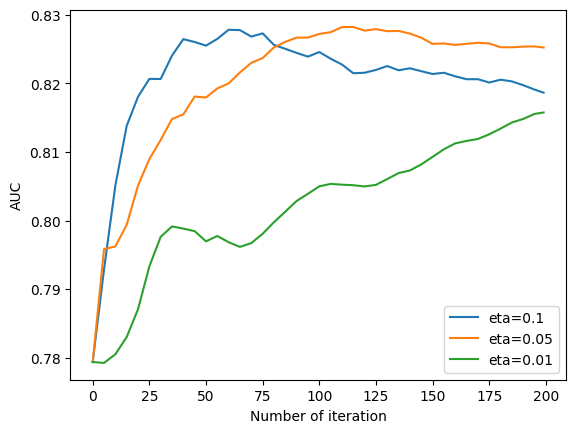

In [220]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']

# for key, df_score in scores.items():
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.iteration, df_score.val_auc, label=eta)

plt.xlabel('Number of iteration')
plt.ylabel('AUC')

plt.legend()

- 0.05 takes almost twice the number of iterations that 0.1 needs to reach the peak
- 0.1 still the best

## Max depth

In [223]:
max_depth = [6, 3, 4, 10]

In [230]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [231]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgb_output(output)

scores.keys()

dict_keys(['eta=0.01', 'eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10'])

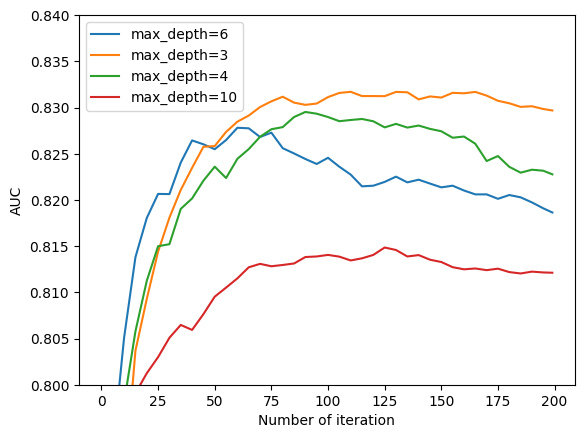

In [236]:
max_depths = ['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10']

for key in max_depths:
    df_score = scores[key]
    plt.plot(df_score.iteration, df_score.val_auc, label=key)

plt.xlabel('Number of iteration')
plt.ylabel('AUC')

plt.ylim(0.8, 0.84)
plt.legend()

Max depth 3 has the best AUC while 10 has the best

## Min child weight

In [237]:
min_child_weight = [1, 10, 30]

In [242]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [243]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)

scores.keys()

dict_keys(['eta=0.01', 'eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10', 'min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

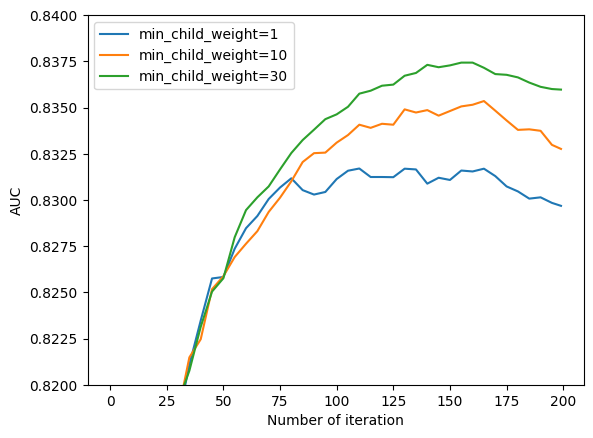

In [246]:
min_child_weights = ['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30']

for key in min_child_weights:
    df_score = scores[key]
    plt.plot(df_score.iteration, df_score.val_auc, label=key)

plt.xlabel('Number of iteration')
plt.ylabel('AUC')

plt.ylim(0.82, 0.84)
plt.legend()

- Min child weight of 30 is the best but the difference is very small, any can work
- 175 iterations look good

## Other parameters: 

Useful ones:

- `subsample` (try 0.6, 0.3) and `colsample_bytree` (try 0.7, 0.5, 0.3)
- `lambda` and `alpha`

In [247]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=175)